
## AutoRec: ['Autoencoders Meet Collaborative Filtering'](https://dl.acm.org/doi/pdf/10.1145/2740908.2742726) Paper Review.
This paper proposes AutoRec, a new CF model based on the autoencoder paradigm. The idea came from the successes of (deep) neural network models for vision and speech tasks.
The main objective of the paper is to show that AutoRec has representational and computational advantages over existing neural
approaches to CF and demonstrate empirically that it outperforms the current state-of-the-art methods.
The approach presented in the paper is to learn a model so that the output is as close as possible to the input,and make sure that the square error is minimum.
In fact, AutoRec main approach is to study vector representation of the original input.
`from input layer->hidden layer, the process of encode. from hidden layer->output layer, it's a decode process.`
this process should create a model that can reconstruct the original data to the maximum extent. The approach came from 'AutoEncoders'


<img height="400" src="images/autorec.png" width="600"/>

## Further work
A further work which may improve significant the model is to make Deep AutoRec. the model should contain more layers, as suggested in this [paper](https://arxiv.org/abs/1708.01715)).
In this review we suggested another version of autorec, AutoRecV2, in this version we added a drop out layer which improved the RMSE loss. this face indicates that deeper models with more layers such as regulizations & and drop-out will improve significantly the predictions.



## Init

In [42]:
import numpy as np
import pandas as pd
import torch
import json
from time import time
from utils.plots import plot_train_history
from utils.models_results import models_results
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## datasets

In this project, we will use 2 datasets:
* **movielens 100k**, which can be downloaded using `utils.datasets_download.py` or straight from [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip).
* **movielens 1m**, which can be downloaded from [here](http://files.grouplens.org/datasets/movielens/ml-1m.zip)
<br>Both datasets needs to be saved in the `data` folder.
#### How to load the datasets?
<br> Using `src.dataprep.py` functions.

For movielens 100k use `movielens_load_100k` to create ['user_id', 'item_id', 'rating'] df and `movielens_create_ratings_100k` to create R matrix.

For movielens 1m use `movielens_load_1m` to create ['user_id', 'item_id', 'rating'] df and `movielens_create_ratings_1m` to create R matrix.

 # Instructions:
 * Each model has his own dataset, model, training in seperate folder under `/src`.
 * In this notebook there are functins with the model name and hyper_params (for example `mf_hyper_params`). Those are the HP loops. To run the HP search use `find=True` and unmark the cell below. If `find=False` then in will print us a table with the models preformens

# Matrix Factorization

In [44]:
from src.mf.model import MatrixFactorization
from src.mf.training import MFTrainer

In [45]:
from src.data_prep import movielens_load_100k
train, test = movielens_load_100k(1)
print(train.shape)
train

(80000, 4)


,user_id,item_id,rating,timestamp
0,0,0,5,874965758
1,0,1,3,876893171
2,0,2,4,878542960
3,0,3,3,876893119
4,0,4,3,889751712
...,...,...,...,...
79995,942,1066,2,875501756
79996,942,1073,4,888640250
79997,942,1187,3,888640250
79998,942,1227,3,888640275


The matrix factorization algorithm uses train / test as the above datframe describes.

In [46]:
# If you wish to find hyper params run `mf_hyper_params` with `find=True`
# It will save the params and losses to models_params folder
# Otherwise it will return a df with the already run models

epochs = 60
batch_size = 64

def mf_hyper_params(find=False):
    if find:
        for k in [10, 15, 20, 50, 100]:
            for lr in [0.001, 0.003, 0.005]:
                for reg in [0.001, 0.003, 0.005]:
                    print(f'STARTING TRAIN MF with k: {k}, lr: {lr}, reg: {reg}')
                    start_time = time()
                    model_dict = {}
                    num_users = train.user_id.max() + 1
                    num_items = train.item_id.max() + 1

                    # Init model and trainer
                    model = MatrixFactorization(num_users, num_items, k=k)
                    mf_trainer = MFTrainer(train, test, model, epochs=epochs, lr=lr, reg=reg, batch_size=batch_size)

                    # Train
                    mf_trainer.train_model()

                    # Save parmas to model_dict
                    model_dict['model_params'] = model.params()
                    model_dict.update(mf_trainer.params())
                    model_dict['train_losses'] = mf_trainer.train_losses
                    model_dict['val_losses'] = mf_trainer.val_losses

                    # Save model params to json file
                    file_name = f'models_params/MF_{k}_{lr}_{reg}'
                    with open(file_name, 'w') as f:
                        json.dump(model_dict, f, indent=4)

                    plot_train_history(mf_trainer.train_losses, mf_trainer.val_losses)
                    print(f'model train time: {time() - start_time:.3f}\n')
        return
    else:
        return models_results('MF')


In [47]:
# mf_results = mf_hyper_params(True)

In [48]:
mf_results = mf_hyper_params(False)
mf_results.sort_values(by='val_loss')

,model_name,train_loss,val_loss,params
9,MF_10_0.001_0.001,2.070330,2.252434,"{'model_params': {'k': 10}, 'seed': 14, 'epoch..."
18,MF_15_0.001_0.001,2.072956,2.254183,"{'model_params': {'k': 15}, 'seed': 14, 'epoch..."
27,MF_20_0.001_0.001,2.074550,2.255035,"{'model_params': {'k': 20}, 'seed': 14, 'epoch..."
36,MF_50_0.001_0.001,2.081092,2.259130,"{'model_params': {'k': 50}, 'seed': 14, 'epoch..."
0,MF_100_0.001_0.001,2.085245,2.261896,"{'model_params': {'k': 100}, 'seed': 14, 'epoc..."
12,MF_10_0.003_0.001,2.087885,2.263649,"{'model_params': {'k': 10}, 'seed': 14, 'epoch..."
21,MF_15_0.003_0.001,2.088505,2.264293,"{'model_params': {'k': 15}, 'seed': 14, 'epoch..."
30,MF_20_0.003_0.001,2.091324,2.266042,"{'model_params': {'k': 20}, 'seed': 14, 'epoch..."
15,MF_10_0.005_0.001,2.092465,2.266833,"{'model_params': {'k': 10}, 'seed': 14, 'epoch..."
24,MF_15_0.005_0.001,2.093361,2.267727,"{'model_params': {'k': 15}, 'seed': 14, 'epoch..."


# AutoRec

In [49]:
from src.data_prep import movielens_create_ratings_100k
train, test = movielens_create_ratings_100k(1)
train

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,5,3,4,3,3,0,4,1,5,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
939,0,0,0,2,0,0,4,5,3,0,...,0,0,0,0,0,0,0,0,0,0
940,5,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The autorec algorithm uses train / test as the above datframe describes.

In [50]:
from src.autorec.model import AutoRec
from src.autorec.training import AutoRecTrainer

In [51]:
# If you wish to find hyper params run `autorec_hyper_params` with `find=True`
# It will save the params and losses to models_params folder
# Otherwise it will return a df with the already run models

epochs = 60
batch_size = 64


def autorec_hyper_params(find=False):
    if find:
        for num_hidden in [100, 200, 500, 600]:
            for lr in [0.001, 0.003, 0.005]:
                for reg in [0.0005, 0.001, 0.003, 0.005]:
                    print(f'STARTING TRAIN AutoRec with num_hidden: {num_hidden}, lr: {lr}, reg: {reg}')
                    start_time = time()
                    model_dict = {}

                    num_users, num_items = train.shape

                    # Init model and trainer
                    model = AutoRec(num_hidden=num_hidden, num_features=num_users)
                    autorec_trainer = AutoRecTrainer(train, test, model, epochs=epochs, batch_size=batch_size, lr=lr, reg=reg)

                    # Train
                    autorec_trainer.train_model()

                    # Save parmas to model_dict
                    model_dict['model_params'] = model.params()
                    model_dict.update(autorec_trainer.params())
                    model_dict['train_losses'] = autorec_trainer.train_losses
                    model_dict['val_losses'] = autorec_trainer.val_losses

                    # Save model params to json file
                    file_name = f'models_params/AutoRec_{num_hidden}_{lr}_{reg}'
                    with open(file_name, 'w') as f:
                        json.dump(model_dict, f, indent=4)

                    plot_train_history(autorec_trainer.train_losses, autorec_trainer.val_losses)
                    print(f'model train time: {time() - start_time:.3f}\n')
        return
    else:
        return models_results('AutoRec_')



In [52]:
# autorec_results = autorec_hyper_params(find=True)

In [53]:
autorec_results = autorec_hyper_params(find=False)
autorec_results.sort_values(by='val_loss')

,model_name,train_loss,val_loss,params
36,AutoRec_600_0.001_0.0005,0.290048,0.984759,"{'model_params': {'num_hidden': 600}, 'seed': ..."
24,AutoRec_500_0.001_0.0005,0.297343,0.987484,"{'model_params': {'num_hidden': 500}, 'seed': ..."
20,AutoRec_200_0.005_0.0005,0.519668,1.002864,"{'model_params': {'num_hidden': 200}, 'seed': ..."
28,AutoRec_500_0.003_0.0005,0.390909,1.005093,"{'model_params': {'num_hidden': 500}, 'seed': ..."
16,AutoRec_200_0.003_0.0005,0.440780,1.008321,"{'model_params': {'num_hidden': 200}, 'seed': ..."
40,AutoRec_600_0.003_0.0005,0.398088,1.021196,"{'model_params': {'num_hidden': 600}, 'seed': ..."
12,AutoRec_200_0.001_0.0005,0.505245,1.037213,"{'model_params': {'num_hidden': 200}, 'seed': ..."
8,AutoRec_100_0.005_0.0005,0.652628,1.051233,"{'model_params': {'num_hidden': 100}, 'seed': ..."
4,AutoRec_100_0.003_0.0005,0.636656,1.057606,"{'model_params': {'num_hidden': 100}, 'seed': ..."
37,AutoRec_600_0.001_0.001,0.562352,1.070791,"{'model_params': {'num_hidden': 600}, 'seed': ..."


# AutoRecV2

In [54]:
from src.data_prep import movielens_create_ratings_100k
train, test = movielens_create_ratings_100k(1)
train

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,5,3,4,3,3,0,4,1,5,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
939,0,0,0,2,0,0,4,5,3,0,...,0,0,0,0,0,0,0,0,0,0
940,5,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The autorec algorithm uses train / test as the above datframe describes.


In [55]:
from src.autorecv2.model import AutoRecV2
from src.autorecv2.training import AutoRecV2Trainer

In [56]:
# If you wish to find hyper params run `autorec_hyper_params` with `find=True`
# It will save the params and losses to models_params folder
# Otherwise it will return a df with the already run models
from time import time

epochs = 60
batch_size = 64


def autorecv2_hyper_params(find=False):
    if find:
        for num_hidden in [256, 512, 650, 800]:
            for lr in [0.0005, 0.001]: #, 0.005]:
                for reg in [0.0005, 0.001]: #, 0.003]:
                    for dropout in [0, 0.05, 0.12, 0.2, 0.3, 0.4]:
                        print(f'STARTING TRAIN AutoRecV2 with num_hidden: {num_hidden}, lr: {lr}, reg: {reg}, dp: {dropout}')
                        start_time = time()
                        model_dict = {}

                        num_users, num_items = train.shape

                        # Init model and trainer
                        model = AutoRecV2(num_hidden=num_hidden, num_features=num_users, dropout=dropout)
                        autorec_trainer = AutoRecV2Trainer(train, test, model, epochs=epochs, batch_size=batch_size, lr=lr, reg=reg)

                        # Train
                        autorec_trainer.train_model()

                        # Save parmas to model_dict
                        model_dict['model_params'] = model.params()
                        model_dict.update(autorec_trainer.params())
                        model_dict['train_losses'] = autorec_trainer.train_losses
                        model_dict['val_losses'] = autorec_trainer.val_losses

                        # Save model params to json file
                        file_name = f'models_params/AutoRecV2_{num_hidden}_{lr}_{reg}'
                        with open(file_name, 'w') as f:
                            json.dump(model_dict, f, indent=4)

                        plot_train_history(autorec_trainer.train_losses, autorec_trainer.val_losses)
                        print(f'model train time: {time() - start_time:.3f}\n')
        return
    else:
        return models_results('AutoRecV2')


In [57]:
# autorecv2_hyper_params(find=True)

In [58]:
autorecv2_results = autorecv2_hyper_params(find=False)
autorecv2_results.sort_values(by='val_loss')

,model_name,train_loss,val_loss,params
12,AutoRecV2_800_0.0005_0.0005,0.521380,0.769009,"{'model_params': {'num_hidden': 800, 'dropout'..."
14,AutoRecV2_800_0.001_0.0005,0.487651,0.778057,"{'model_params': {'num_hidden': 800, 'dropout'..."
10,AutoRecV2_650_0.001_0.0005,0.512542,0.778519,"{'model_params': {'num_hidden': 650, 'dropout'..."
8,AutoRecV2_650_0.0005_0.0005,0.561104,0.779647,"{'model_params': {'num_hidden': 650, 'dropout'..."
6,AutoRecV2_512_0.001_0.0005,0.546447,0.792634,"{'model_params': {'num_hidden': 512, 'dropout'..."
4,AutoRecV2_512_0.0005_0.0005,0.606374,0.797822,"{'model_params': {'num_hidden': 512, 'dropout'..."
13,AutoRecV2_800_0.0005_0.001,0.694199,0.820141,"{'model_params': {'num_hidden': 800, 'dropout'..."
2,AutoRecV2_256_0.001_0.0005,0.678756,0.829820,"{'model_params': {'num_hidden': 256, 'dropout'..."
15,AutoRecV2_800_0.001_0.001,0.698225,0.833807,"{'model_params': {'num_hidden': 800, 'dropout'..."
9,AutoRecV2_650_0.0005_0.001,0.716994,0.834385,"{'model_params': {'num_hidden': 650, 'dropout'..."


# Models Comparison (on movielens 100k)

In [59]:
all_models = models_results()

In [60]:
best_df = pd.DataFrame(columns=all_models.columns)
for i, model_name in enumerate(['MF', 'AutoRec_', 'AutoRecV2']):
    temp = models_results(model_name)
    temp = temp.sort_values(by='val_loss')[:2]
    best_df = pd.concat([best_df, temp], axis=0)

best_df.sort_values(by='val_loss')[['model_name', 'val_loss']]

,model_name,val_loss
12,AutoRecV2_800_0.0005_0.0005,0.769009
14,AutoRecV2_800_0.001_0.0005,0.778057
36,AutoRec_600_0.001_0.0005,0.984759
24,AutoRec_500_0.001_0.0005,0.987484
9,MF_10_0.001_0.001,2.252434
18,MF_15_0.001_0.001,2.254183


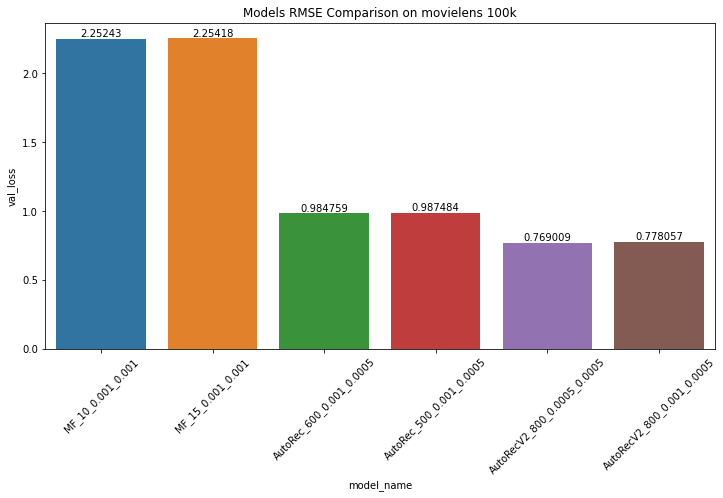

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
ax = sns.barplot(x='model_name', y='val_loss', data=best_df)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.title('Models RMSE Comparison on movielens 100k');

# Compare 3 best models on movielens 1M

**NOTE:** unmark the cell below to train the 3 best models on movielens 1M

In [62]:
# from src.data_prep import movielens_load_1m, movielens_create_ratings_1m
# # Init MF dataset
# mf_train, mf_test = movielens_load_1m()
# mf_num_users, mf_num_items = (6040, 3952)
#
# # Init AutoRec and AutoRecV2 dataset
# autorec_train, autorec_test = movielens_create_ratings_1m()
# autorec_num_users, autorec_num_items = autorec_train.shape
#
# # Init batch_size and epochs
# epochs = 30
# batch_size = 64
#
# # Init models and trainers
# best_3_models = {
#     'autorec': AutoRec(num_hidden=600, num_features=autorec_num_users),
#     'autorec_v2': AutoRecV2(num_features=autorec_num_users, num_hidden=800, dropout=0.25),
#     'mf': MatrixFactorization(mf_num_users, mf_num_items, k=100),
# }
#
# trainers = {
#     'autorec': AutoRecTrainer(autorec_train, autorec_test, model=best_3_models['autorec'],
#                               lr=0.001, reg=0.0005, batch_size=batch_size, epochs=epochs),
#     'autorec_v2': AutoRecV2Trainer(autorec_train, autorec_test, model=best_3_models['autorec'],
#                                  lr=0.001, reg=0.0005, batch_size=batch_size, epochs=epochs),
#     'mf': MFTrainer(mf_train, mf_test, model=best_3_models['mf'],
#                     lr=0.001, reg=0.001, batch_size=batch_size, epochs=epochs),
# }
#
# # Train 3 models
# for model_name, model in best_3_models.items():
#     print(f'START TRAIN {model_name}')
#     start_time = time()
#     model_dict = {}
#
#     model_trainer = trainers[model_name]
#     model_trainer.train_model()
#
#     # Save parmas to model_dict
#     model_dict['model_params'] = model.params()
#     model_dict.update(model_trainer.params())
#     model_dict['train_losses'] = model_trainer.train_losses
#     model_dict['val_losses'] = model_trainer.val_losses
#
#     # Save model params to json file
#     file_name = f'models_params/top3_{model_name}'
#     with open(file_name, 'w') as f:
#         json.dump(model_dict, f, indent=4)
#
#     plot_train_history(model_trainer.train_losses, model_trainer.val_losses)
#     print(f'model train time: {time() - start_time:.3f}\n')
#


In [63]:
top3 = models_results('top3').sort_values(by='val_loss')
top3

,model_name,train_loss,val_loss,params
1,top3_autorec_v2,0.852670,1.185503,"{'model_params': {'num_hidden': 800, 'dropout'..."
0,top3_autorec,0.858982,1.205304,"{'model_params': {'num_hidden': 600}, 'seed': ..."
2,top3_mf,3.749790,3.748498,"{'model_params': {'k': 100}, 'seed': 14, 'epoc..."


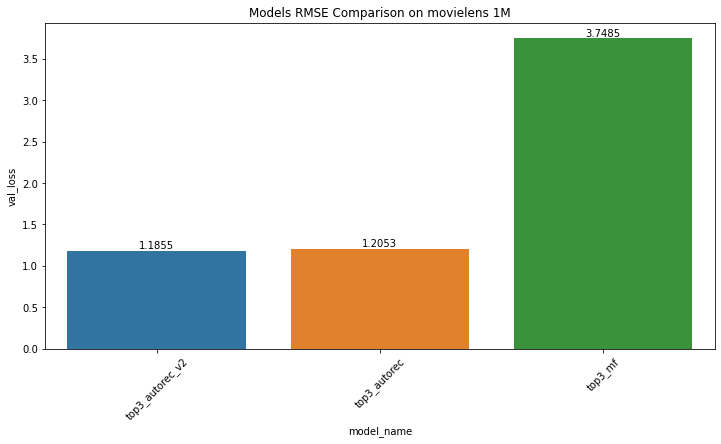

In [64]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x='model_name', y='val_loss', data=top3)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.title('Models RMSE Comparison on movielens 1M');

# Summery
In this review, we covered the "AutoRec meets CF" paper.

We started by choosing matrix factorization as our baseline model. Following that, we implemented the AutoRec model as suggested in the paper, and then suggested an improvement to it.
The suggestion was to add a dropout to the encoding layer. By adding the dropout, we anticipated that the model would be more generalized, prevent overfitting, and perform better on the validation set.
As in the paper, we used the RMSE metric as a comparison metric.
On the "movielens100k" dataset, we tested the models and found the best hyperparameters. Then we applied those parameters to the "movielens 1M" dataset.
The AutoRec model outperformed the matrix factorization, and our model achieved even better results than both.